In [21]:
#setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib as mpl
import itertools as it
mpl.rcParams['pdf.fonttype'] = 42


def get_colormap(colors, N = 256):
    return clr.LinearSegmentedColormap.from_list('custom', colors, N=N) if len(colors) > 1 else plt.get_cmap(*colors)


def get_bin_index(site, leftBound, rightBound, binsize):
    binbounds = np.arange(leftBound, rightBound, binsize)
    # -1 because 0-based indices
    return len(np.where(binbounds < site)[0]) - 1 \
           if not (site < binbounds[0] or site > binbounds[-1]) \
           else None


def annotate_contacts(ax, 
                      contacts, 
                      r = 2.5, 
                      linestyle = '--', 
                      edgecolor = 'k',
                      mirror_horizontal = False):
    t = np.array([[1, 0.5], [-1, 0.5]]) if mirror_horizontal else np.array([[-1, 0.5], [1, 0.5]])
    
    for x, y in contacts:
        M = np.array([[x, y]])
        M = np.dot(M, t)
        ax.add_patch(patches.Circle((M[:, 1], M[:, 0]), 
                                    radius = r,
                                    fill = False,
                                    ls = linestyle,
                                    edgecolor = edgecolor,
                                    zorder = 3))

igh = (114435000, 114669000)
interacting_regions = {'3CBE3RR': (114453981, 114492784),
                        '3CBEhs4': (114453981, 114466981),
                        '3CBE': (114453981, 114463472),
                        '3RR': (114466175, 114492784),
                        '3RR+': (114463472, 114492784),
                        'hs4': (114466175, 114466981),
                        'hs3b+4': (114466175, 114471105),
                        'hs3a': (114491704, 114492784),
                        'hs1,2': (114482373, 114483741),
                        'Em': (114664789, 114666183),
                        'Sm': (114662156, 114666183),
                        'mu': (114657164, 114666183),
                        'mu+': (114655000, 114666183),
                        'muDelta': (114652483, 114666183),
                        'SmCm': (114657164, 114664070),
                        'IgG1': (114577464, 114577709),
                        'IgG1+-2kb': (114577464-2000, 114577709+2000),
                        'CG1_3SG1': (114564902, 114572600),
                        'G1': (114564902, 114577582),
                        'G1+5kb': (114564902, 114577582+5000)}

In [22]:
# reading in samplenames and subset for IgG1 samples of mouse
samplenames = pd.read_csv('resource/sampleinfo_TriC_11.tsv', 
                          sep = '\t', 
                          header = None, 
                          names = ['name', 'capture', 'genome'])
n = 'AIDKO'
samplenames = samplenames.loc[samplenames.capture.str.startswith(tuple(['hs4_capture', 'Emu_capture'])) & 
                              (samplenames.genome == 'mm9') &
                              samplenames.name.str.startswith(tuple(['TriC_11_lane_2_Spt5']))] \
                         .reset_index(drop = True)

samplenames


,name,capture,genome
0,TriC_11_lane_2_Spt5_2_ctrl_1,Emu_capture,mm9
1,TriC_11_lane_2_Spt5_2_ctrl_2,Emu_capture,mm9
2,TriC_11_lane_2_Spt5_2_KO_1,Emu_capture,mm9
3,TriC_11_lane_2_Spt5_2_KO_2,Emu_capture,mm9
4,TriC_11_lane_2_Spt5_2_KO_3,Emu_capture,mm9


In [23]:
# reading in samplenames and subset for IgG1 samples of mouse
samplenames2 = pd.read_csv('resource/sampleinfo_TriC_10.tsv', 
                          sep = '\t', 
                          header = None, 
                          names = ['name', 'capture', 'genome'])
n = 'AIDKO'
samplenames2 = samplenames2.loc[samplenames2.capture.str.startswith(tuple(['hs4_capture', 'Emu_capture'])) & 
                              (samplenames2.genome == 'mm9') &
                              samplenames2.name.str.startswith(tuple(['TriC_10_lane_2_Spt5']))] \
                         .reset_index(drop = True)
samplenames2


,name,capture,genome
0,TriC_10_lane_2_Spt5_2_KO_1,hs4_capture,mm9
1,TriC_10_lane_2_Spt5_2_KO_2,hs4_capture,mm9
2,TriC_10_lane_2_Spt5_2_KO_3,hs4_capture,mm9
3,TriC_10_lane_2_Spt5_2_ctrl_1,hs4_capture,mm9
4,TriC_10_lane_2_Spt5_2_ctrl_2,hs4_capture,mm9


In [24]:
samplenames = pd.concat([samplenames, samplenames2])
samplenames

,name,capture,genome
0,TriC_11_lane_2_Spt5_2_ctrl_1,Emu_capture,mm9
1,TriC_11_lane_2_Spt5_2_ctrl_2,Emu_capture,mm9
2,TriC_11_lane_2_Spt5_2_KO_1,Emu_capture,mm9
3,TriC_11_lane_2_Spt5_2_KO_2,Emu_capture,mm9
4,TriC_11_lane_2_Spt5_2_KO_3,Emu_capture,mm9
0,TriC_10_lane_2_Spt5_2_KO_1,hs4_capture,mm9
1,TriC_10_lane_2_Spt5_2_KO_2,hs4_capture,mm9
2,TriC_10_lane_2_Spt5_2_KO_3,hs4_capture,mm9
3,TriC_10_lane_2_Spt5_2_ctrl_1,hs4_capture,mm9
4,TriC_10_lane_2_Spt5_2_ctrl_2,hs4_capture,mm9


In [25]:
# reading matrices and setting capture bins to 0
mats = {}
cbinidx = [get_bin_index(interacting_regions['Em'][0], igh[0], igh[1], 1000), get_bin_index(interacting_regions['hs4'][0], igh[0], igh[1], 1000)]
for name in samplenames.name:
    m = np.loadtxt(f'TriCplots/{name}_TriC_interactions_1000_RAW.tab',
                   delimiter = '\t')
    for capture in cbinidx:
        m[capture, :] = 0
        m[:, capture] = 0
    mats[name] = m


In [26]:
def sum_contacts(m, contact_regions, total_region, binsize = 1000, r = 0):
    idxs = []
    contact_sum = 0
    contact_regions = sorted(contact_regions, key=lambda tup: tup[0])
    for contact_region in it.combinations(contact_regions, 2):
        region_idxs = []
        for start, end in contact_region:
            width = end - start
            
            if r and width < binsize * (2 * r + 1):
                mid = start + (end - start)//2
                midbin = get_bin_index(mid, total_region[0], total_region[1], binsize)
                startbin = midbin - r
                endbin = midbin + r + 1
                
            else:
                startbin = get_bin_index(start, total_region[0], total_region[1], binsize)
                endbin = get_bin_index(end, total_region[0], total_region[1], binsize) + 1

            region_idxs.append((startbin, endbin))
            
        contact_sum += m[region_idxs[0][0]: region_idxs[0][1], region_idxs[1][0]: region_idxs[1][1]].sum()
        idxs.append(region_idxs)
    
    return contact_sum, idxs

In [27]:
regions1 = ['CG1_3SG1', 'IgG1+-2kb']
regions2 = ['mu', '3CBEhs4']

contactsums = []
for sample, capture in zip(samplenames.name, samplenames.capture):
    if sample[-2] == '+': # Exeption for TriC12-13 because replicates 1 and 3 are already pooled for d0 samples (look at names)
        n = 1
        name = sample[:-4]
    else: 
        n = int(sample[-1:])
        name = sample[:-2]
    m = mats[sample]
    for region1, region2 in it.product(regions1, regions2):
        contact_sum, idxs = sum_contacts(m, 
                                         [interacting_regions[region1], 
                                          interacting_regions[region2]], 
                                         igh,
                                         binsize=1000,
                                         r = 2)
        
        idxs = idxs[0]
        region1_bincount = idxs[0][1] - idxs[0][0]
        region2_bincount = idxs[1][1] - idxs[1][0]
        squarebins = region1_bincount * region2_bincount

        pcontacts = contact_sum#/squarebins #normalize by number of bins in reg. of interest (=squarebins)
        contactsums.append([name, n, capture, region1, region2, pcontacts])
        
contactsums = pd.DataFrame(contactsums, columns = ['sample', 'replicate', 'capture', 'region1', 'region2', 'pinteractions'])
contactsums = contactsums[contactsums['region1'] != contactsums['region2']]
contactsums = contactsums.sort_values(['sample', 'replicate'])
contactsums

,sample,replicate,capture,region1,region2,pinteractions
20,TriC_10_lane_2_Spt5_2_KO,1,hs4_capture,CG1_3SG1,mu,80.06
21,TriC_10_lane_2_Spt5_2_KO,1,hs4_capture,CG1_3SG1,3CBEhs4,1392.31
22,TriC_10_lane_2_Spt5_2_KO,1,hs4_capture,IgG1+-2kb,mu,204.37
23,TriC_10_lane_2_Spt5_2_KO,1,hs4_capture,IgG1+-2kb,3CBEhs4,397.60
24,TriC_10_lane_2_Spt5_2_KO,2,hs4_capture,CG1_3SG1,mu,65.18
25,TriC_10_lane_2_Spt5_2_KO,2,hs4_capture,CG1_3SG1,3CBEhs4,646.87
26,TriC_10_lane_2_Spt5_2_KO,2,hs4_capture,IgG1+-2kb,mu,338.35
27,TriC_10_lane_2_Spt5_2_KO,2,hs4_capture,IgG1+-2kb,3CBEhs4,500.27
28,TriC_10_lane_2_Spt5_2_KO,3,hs4_capture,CG1_3SG1,mu,72.55
29,TriC_10_lane_2_Spt5_2_KO,3,hs4_capture,CG1_3SG1,3CBEhs4,545.27


In [28]:
tmp = contactsums.groupby('capture')
for (capture, group) in tmp:
	regiongroups = group.groupby('region1')
	# for i in zip(group['region1'], group['region2']): print(i)
	for i in regiongroups: print(i)


# sns.load_dataset('penguins')

('CG1_3SG1',                         sample  replicate      capture   region1  region2  \
8     TriC_11_lane_2_Spt5_2_KO          1  Emu_capture  CG1_3SG1       mu   
9     TriC_11_lane_2_Spt5_2_KO          1  Emu_capture  CG1_3SG1  3CBEhs4   
12    TriC_11_lane_2_Spt5_2_KO          2  Emu_capture  CG1_3SG1       mu   
13    TriC_11_lane_2_Spt5_2_KO          2  Emu_capture  CG1_3SG1  3CBEhs4   
16    TriC_11_lane_2_Spt5_2_KO          3  Emu_capture  CG1_3SG1       mu   
17    TriC_11_lane_2_Spt5_2_KO          3  Emu_capture  CG1_3SG1  3CBEhs4   
0   TriC_11_lane_2_Spt5_2_ctrl          1  Emu_capture  CG1_3SG1       mu   
1   TriC_11_lane_2_Spt5_2_ctrl          1  Emu_capture  CG1_3SG1  3CBEhs4   
4   TriC_11_lane_2_Spt5_2_ctrl          2  Emu_capture  CG1_3SG1       mu   
5   TriC_11_lane_2_Spt5_2_ctrl          2  Emu_capture  CG1_3SG1  3CBEhs4   

    pinteractions  
8          115.05  
9          472.78  
12         490.52  
13         495.96  
16           0.00  
17         896.03  

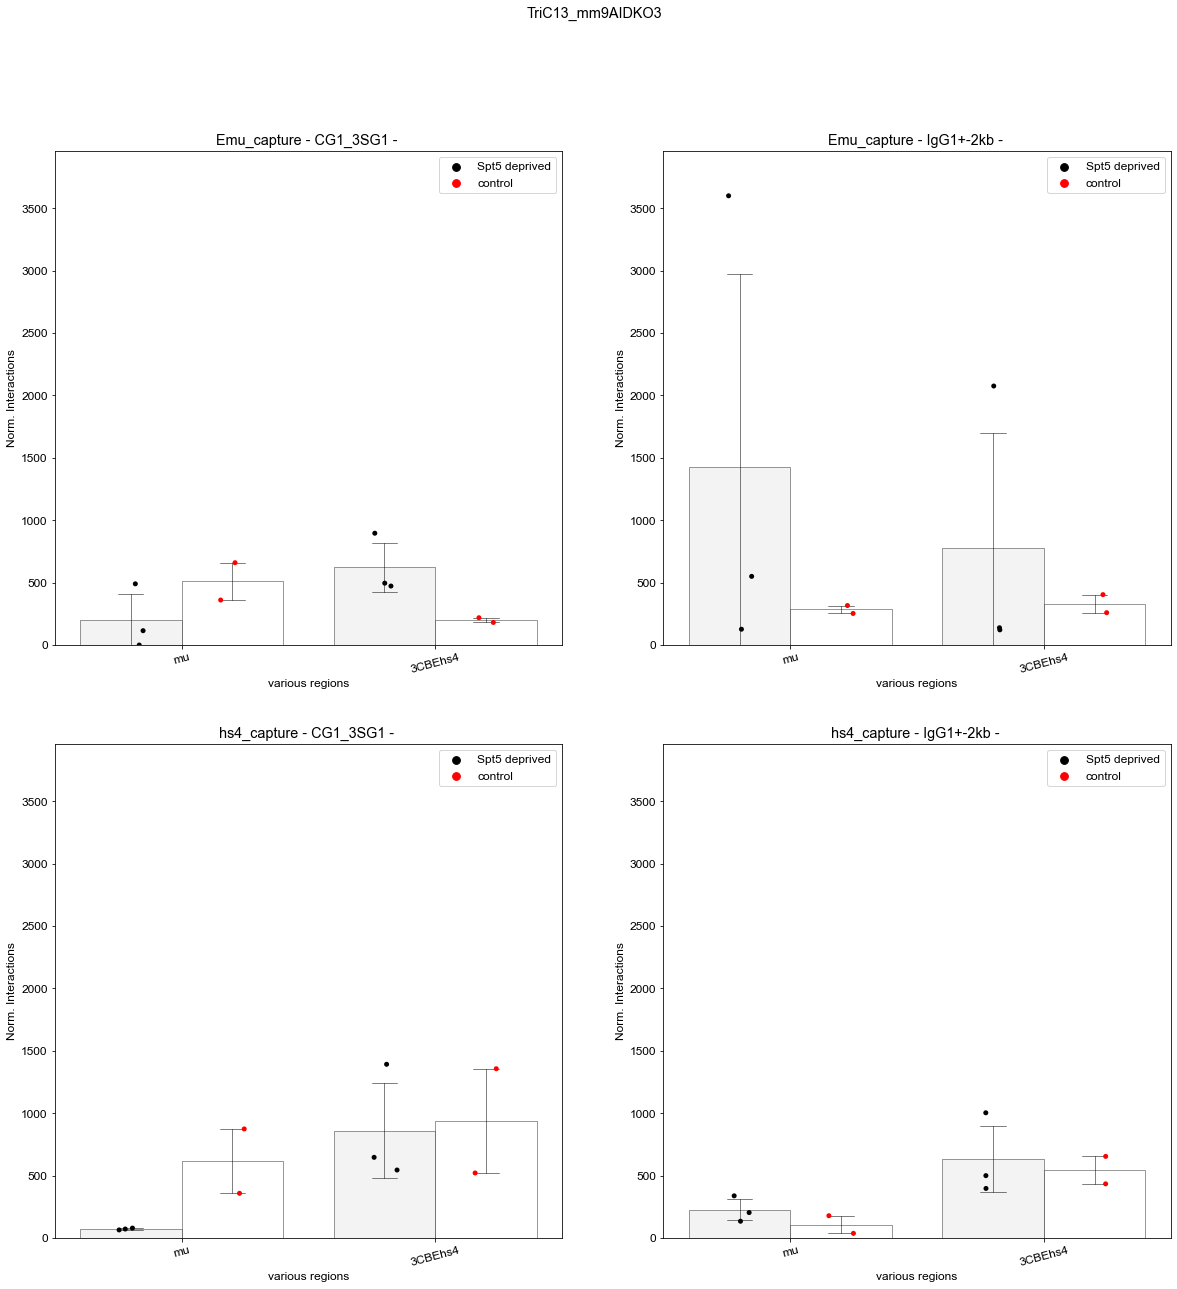

In [29]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 0.5

fig = plt.figure(figsize=(20,20))

maxInteraction = max(contactsums['pinteractions'])
maxInteraction = maxInteraction + maxInteraction/10

axCounter = 1
for (capture, group) in contactsums.groupby('capture'): # for each capture
	for (region1, group2) in group.groupby('region1'): # for each region1
		ax = fig.add_subplot(len(set(contactsums.capture)), len(set(group.region1)), axCounter)
		axCounter = axCounter + 1
		sns.barplot(data=group2, x='region2', y='pinteractions', hue='sample', ci='sd', color='white', linewidth=0.5, edgecolor='black', 
			errcolor='black', errwidth=0.5, capsize=0.1, alpha=0.8, ax=ax)
		sns.stripplot(data=group2, x='region2', y='pinteractions', hue='sample', ax=ax, dodge=True, size=5,
			palette=['black', 'red'])
		handles, labels = ax.get_legend_handles_labels()
		ax.legend_.remove()
		ax.legend(handles, ['Spt5 deprived', 'control'])
		# ax.set_ylabel('Norm. Interactions / bin')
		ax.set_ylabel('Norm. Interactions')
		ax.set_xlabel("various regions")
		ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
		ax.set_title(f'{capture} - {region1} - ')
		ax.set_ylim(0, maxInteraction)

fig.suptitle('TriC13_mm9AIDKO3')

fig.savefig('plots/TriC10/TriC10&11_mm9Spt5_RegOfInterest_Emu&hs4Cap.pdf')


In [30]:
# for (capture, group) in contactsums.groupby('capture'): # for each subplot / capture
# 	print(f'{capture} - {group["region2"][0]} - various 3RR regions')